In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# !pip install tf-nightly-2.0-preview


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 21.5167 - mae: 22.0115 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 21.1522 - mae: 21.6444 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 20.7302 - mae: 21.2236 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 20.2834 - mae: 20.7757 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 19.7897 - mae: 20.2855 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 19.1782 - mae: 19.6696 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 18.2410 - mae: 18.7333 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 17.4825 - mae: 17.9748 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 14ms/step - loss: 17.1597 - mae:

Epoch 73/100
31/31 [==============================] - 0s 15ms/step - loss: 6.8020 - mae: 7.2896 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 0s 15ms/step - loss: 5.2648 - mae: 5.7440 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 15ms/step - loss: 5.3521 - mae: 5.8339 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 15ms/step - loss: 5.2939 - mae: 5.7731 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 15ms/step - loss: 7.3981 - mae: 7.8834 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 14ms/step - loss: 5.8288 - mae: 6.3076 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 14ms/step - loss: 5.7777 - mae: 6.2622 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 14ms/step - loss: 6.3429 - mae: 6.8241 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 14ms/step - loss: 6.7468 - mae: 7.2365 

(1e-08, 0.0001, 0.0, 30.0)

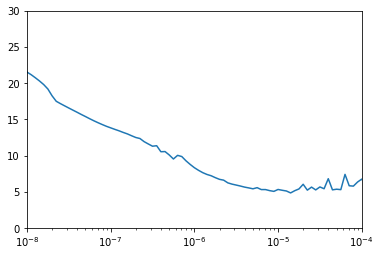

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
31/31 [==============================] - 1s 16ms/step - loss: 774.5386 - mae: 21.3922
Epoch 2/500
31/31 [==============================] - 0s 15ms/step - loss: 121.7481 - mae: 8.3318
Epoch 3/500
31/31 [==============================] - 0s 15ms/step - loss: 136.0198 - mae: 8.9841
Epoch 4/500
31/31 [==============================] - 0s 15ms/step - loss: 155.9337 - mae: 9.4422
Epoch 5/500
31/31 [==============================] - 0s 15ms/step - loss: 177.2073 - mae: 10.4983
Epoch 6/500
31/31 [==============================] - 0s 15ms/step - loss: 91.2104 - mae: 7.3619
Epoch 7/500
31/31 [==============================] - 1s 19ms/step - loss: 151.1987 - mae: 9.5981
Epoch 8/500
31/31 [==============================] - 1s 20ms/step - loss: 142.6590 - mae: 9.1887
Epoch 9/500
31/31 [==============================] - 1s 22ms/step - loss: 174.9566 - mae: 10.2994
Epoch 10/500
31/31 [==============================] - 1s 20ms/step - loss: 150.6328 - mae: 9.7915
Epoch 11/500
31/31 [=======

31/31 [==============================] - 0s 15ms/step - loss: 51.6623 - mae: 5.4844
Epoch 86/500
31/31 [==============================] - 0s 15ms/step - loss: 44.8040 - mae: 5.0531
Epoch 87/500
31/31 [==============================] - 0s 14ms/step - loss: 50.7399 - mae: 5.3734
Epoch 88/500
31/31 [==============================] - 0s 15ms/step - loss: 46.8823 - mae: 5.1858
Epoch 89/500
31/31 [==============================] - 0s 14ms/step - loss: 44.9970 - mae: 5.1360
Epoch 90/500
31/31 [==============================] - 0s 14ms/step - loss: 45.9541 - mae: 5.1307
Epoch 91/500
31/31 [==============================] - 0s 14ms/step - loss: 57.0655 - mae: 5.8890
Epoch 92/500
31/31 [==============================] - 0s 14ms/step - loss: 49.4258 - mae: 5.3724
Epoch 93/500
31/31 [==============================] - 0s 16ms/step - loss: 49.8430 - mae: 5.3813
Epoch 94/500
31/31 [==============================] - 0s 16ms/step - loss: 48.0009 - mae: 5.2505
Epoch 95/500
31/31 [=======================

31/31 [==============================] - 0s 14ms/step - loss: 42.4727 - mae: 4.9899
Epoch 169/500
31/31 [==============================] - 0s 14ms/step - loss: 53.1303 - mae: 5.6291
Epoch 170/500
31/31 [==============================] - 0s 16ms/step - loss: 44.7934 - mae: 5.1461
Epoch 171/500
31/31 [==============================] - 0s 15ms/step - loss: 41.1437 - mae: 4.8520
Epoch 172/500
31/31 [==============================] - 0s 15ms/step - loss: 46.6132 - mae: 5.1670
Epoch 173/500
31/31 [==============================] - 0s 15ms/step - loss: 41.2717 - mae: 4.8439
Epoch 174/500
31/31 [==============================] - 0s 16ms/step - loss: 50.1029 - mae: 5.3724
Epoch 175/500
31/31 [==============================] - 0s 16ms/step - loss: 42.8969 - mae: 4.9847
Epoch 176/500
31/31 [==============================] - 0s 16ms/step - loss: 42.1802 - mae: 4.9322
Epoch 177/500
31/31 [==============================] - 0s 15ms/step - loss: 42.3901 - mae: 4.9248
Epoch 178/500
31/31 [=============

31/31 [==============================] - 1s 17ms/step - loss: 39.3071 - mae: 4.7281
Epoch 252/500
31/31 [==============================] - 1s 17ms/step - loss: 47.1390 - mae: 5.2884
Epoch 253/500
31/31 [==============================] - 1s 17ms/step - loss: 41.0926 - mae: 4.8204
Epoch 254/500
31/31 [==============================] - 0s 16ms/step - loss: 40.1125 - mae: 4.7897
Epoch 255/500
31/31 [==============================] - 1s 17ms/step - loss: 48.8208 - mae: 5.3475
Epoch 256/500
31/31 [==============================] - 1s 17ms/step - loss: 42.5957 - mae: 4.9432
Epoch 257/500
31/31 [==============================] - 1s 18ms/step - loss: 49.5717 - mae: 5.4045
Epoch 258/500
31/31 [==============================] - 1s 18ms/step - loss: 41.1695 - mae: 4.8703
Epoch 259/500
31/31 [==============================] - 1s 17ms/step - loss: 41.3308 - mae: 4.9206
Epoch 260/500
31/31 [==============================] - 0s 16ms/step - loss: 49.7000 - mae: 5.3703
Epoch 261/500
31/31 [=============

31/31 [==============================] - 1s 18ms/step - loss: 37.1624 - mae: 4.6022
Epoch 335/500
31/31 [==============================] - 1s 18ms/step - loss: 41.7201 - mae: 4.9647
Epoch 336/500
31/31 [==============================] - 1s 16ms/step - loss: 47.0081 - mae: 5.2810
Epoch 337/500
31/31 [==============================] - 1s 17ms/step - loss: 43.6490 - mae: 5.0838
Epoch 338/500
31/31 [==============================] - 1s 17ms/step - loss: 41.7315 - mae: 4.8772
Epoch 339/500
31/31 [==============================] - 1s 17ms/step - loss: 41.1399 - mae: 4.8565
Epoch 340/500
31/31 [==============================] - 1s 17ms/step - loss: 41.3815 - mae: 4.9059
Epoch 341/500
31/31 [==============================] - 1s 17ms/step - loss: 42.1109 - mae: 4.9568
Epoch 342/500
31/31 [==============================] - 1s 18ms/step - loss: 50.2455 - mae: 5.4715
Epoch 343/500
31/31 [==============================] - 1s 19ms/step - loss: 46.4422 - mae: 5.2124
Epoch 344/500
31/31 [=============

31/31 [==============================] - 1s 16ms/step - loss: 37.8859 - mae: 4.6361
Epoch 418/500
31/31 [==============================] - 1s 16ms/step - loss: 38.1032 - mae: 4.6866
Epoch 419/500
31/31 [==============================] - 0s 16ms/step - loss: 38.3686 - mae: 4.6731
Epoch 420/500
31/31 [==============================] - 0s 16ms/step - loss: 38.8219 - mae: 4.7196
Epoch 421/500
31/31 [==============================] - 0s 16ms/step - loss: 41.5559 - mae: 4.9393
Epoch 422/500
31/31 [==============================] - 1s 17ms/step - loss: 42.3089 - mae: 4.9581
Epoch 423/500
31/31 [==============================] - 0s 15ms/step - loss: 35.9680 - mae: 4.5562
Epoch 424/500
31/31 [==============================] - 0s 15ms/step - loss: 36.1750 - mae: 4.5394
Epoch 425/500
31/31 [==============================] - 0s 15ms/step - loss: 37.3960 - mae: 4.6159
Epoch 426/500
31/31 [==============================] - 0s 15ms/step - loss: 40.6194 - mae: 4.9179
Epoch 427/500
31/31 [=============

31/31 [==============================] - 0s 15ms/step - loss: 35.5610 - mae: 4.5269


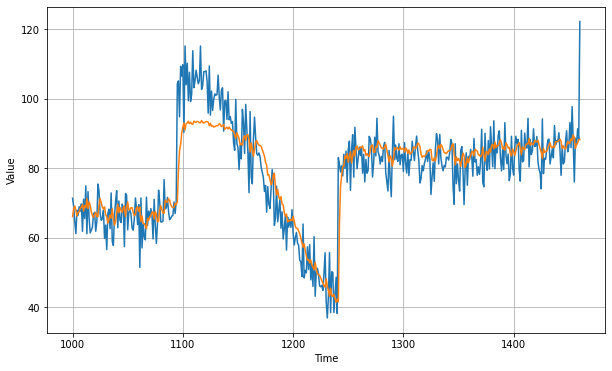

In [8]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.538852

<Figure size 432x288 with 0 Axes>

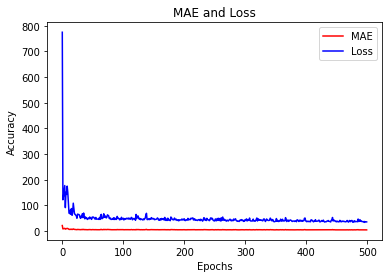

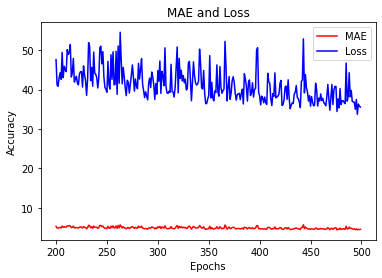

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [11]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 16ms/step - loss: 739.1973
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 108.6536
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 74.2263
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 66.8336
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 63.2463
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 60.6564
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 57.7060
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 60.1065
Epoch 9/100
31/31 [==============================] - 0s 14ms/step - loss: 50.8930
Epoch 10/100
31/31 [==============================] - 0s 15ms/step - loss: 50.2056
Epoch 11/100
31/31 [==============================] - 0s 14ms/step - loss: 51.2970
Epoch 12/100
31/31 [==============================] - 0s 14ms/step - loss: 53.6144
Epoch 13/10

31/31 [==============================] - 0s 14ms/step - loss: 45.6529
Epoch 100/100
31/31 [==============================] - 0s 14ms/step - loss: 55.1726


In [ ]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)